### Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Sklearn import
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import median_absolute_error, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA

# Misc
import time
from tqdm import tqdm

### Load dataset

In [2]:
data = pd.read_csv('marketing_campaign.csv')
data

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,4/9/2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,8/3/2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10/2/2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,13-06-2013,46,709,...,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,10/6/2014,56,406,...,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,25-01-2014,91,908,...,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,24-01-2014,8,428,...,3,0,0,0,0,0,0,3,11,0


### Preprocess the data

In [3]:
# Replace Education and Marital_Status from categorical to numerical
enc = OneHotEncoder()
data_enc= pd.DataFrame(enc.fit_transform(data[['Education']]).toarray(), 
                   columns=['2n Cycle', 'Basic', 'Graduation', 'Master', 'PhD'])
data = data.join(data_enc)
data_enc1 = pd.DataFrame(enc.fit_transform(data[['Marital_Status']]).toarray(),
                       columns=['Absurd', 'Alone', 'Divorced', 'Married', 'Single', 'Together','Widow', 'YOLO'])
data = data.join(data_enc1)

In [4]:
# The column Dt_Customer, education and martial status that are either poorly organized
# or changed from categorical to numerical. 
data = data.drop(['Dt_Customer', 'Education', 'Marital_Status'], axis=1)

In [5]:
# Replace the nans with the mean and move label to the last column 
data.fillna(data.mean(), inplace=True)
response = data.pop('Response')
data.insert(38, 'Response', response)

### Split Data

In [6]:
# split the data
X = data.iloc[:, 1:-1].values   # not include the id number
y = data.iloc[:,-1].values

In [7]:
print(f'percent of customers that responded yes are {y[y==1].shape[0]/y.shape[0]} and has {y[y==1].shape[0]}')
print(f'percent of customers that responded yes are {y[y==0].shape[0]/y.shape[0]} and has {y[y==0].shape[0]}')

percent of customers that responded yes are 0.14910714285714285 and has 334
percent of customers that responded yes are 0.8508928571428571 and has 1906


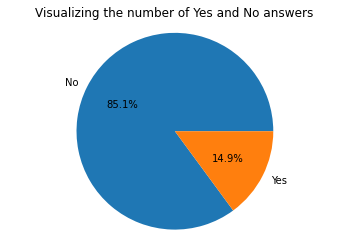

In [15]:
label = ['No', 'Yes']
sizes = [y[y==0].shape[0]/y.shape[0], y[y==1].shape[0]/y.shape[0]]

plt.pie(sizes, labels=label, autopct='%1.1f%%')
plt.title('Visualizing the number of Yes and No answers')
plt.axis('equal')
plt.show()


### The target  response 0 dominates 1 showing clear class imbalance. This may cause a bias in our model because of the influence of one class. Therefore in order to account for this imbalance, I performed resampling of the data where the ratio of yes and no response was 3:4. 

## Part 1
### Develop baseline model
#### baseline model function

In [16]:
def kfold_baseline(model,x_data,y_data, folds, m = 200, n=200):
    kf = KFold(folds)
    np.random.seed(41)
    
    pred_accu =[] 
    for train_idx, test_idx in kf.split(list(range(len(y)))):
        
        id1 = np.argwhere(y[train_idx] == 0)[:,0]
        id2 = np.argwhere(y[train_idx] == 1)[:,0]
        
        rn1 = np.random.choice(id1, n)
        rn2 = np.random.choice(id2, m)
        
        sampled_x1 = x_data[train_idx][rn1]
        sampled_x2 = x_data[train_idx][rn2]
        combined = np.concatenate([sampled_x1, sampled_x2])
        
        labels = np.ones(len(combined))
        labels[0:n] = 0
        labels[n:n+m] = 1
        
        model.fit(combined, labels)
        y_pred = model.predict(x_data[test_idx])
        acc = accuracy_score(y_pred, y_data[test_idx])
        pred_accu.append(acc)
        
        
    return pred_accu
    

### Model performance on baseline data

In [17]:
log_model = kfold_baseline(LogisticRegression(multi_class='ovr', solver='liblinear'), X, y, 5, m=300, n=400)
rf_model = kfold_baseline(RandomForestClassifier(100), X, y, 5, n=100)
svm_model = kfold_baseline(SVC(), X, y, 5, n=100)

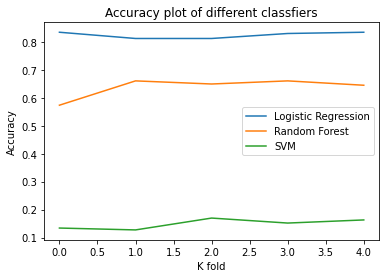

In [18]:
plt.plot(log_model, label='Logistic Regression')
plt.plot(rf_model, label='Random Forest')
plt.plot(svm_model, label='SVM')
plt.title('Accuracy plot of different classfiers')
plt.xlabel('K fold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Part 2
### Compare different feature selection algorithms

In [19]:
def do_kfold_feature_selection(model, x_data, y_data, features='all', folds=5, algo=None, m=300, n=400):
     
    # Do KFold
    kf = KFold(folds)
    
    # KF training
    pred_accuracy = []
    fit_times = []
    for idx, (train_idx, test_idx) in tqdm(enumerate(kf.split(x_data))):
        ## resample the data
        id1 = np.argwhere(y[train_idx] == 0)[:,0]
        id2 = np.argwhere(y[train_idx] == 1)[:,0]
        
        rn1 = np.random.choice(id1, n)
        rn2 = np.random.choice(id2, m)
        
        sampled_x1 = x_data[train_idx][rn1]
        sampled_x2 = x_data[train_idx][rn2]
        combined = np.concatenate([sampled_x1, sampled_x2])
        
        labels = np.ones(len(combined))
        labels[0:n] = 0
        labels[n:n+m] = 1
        
        # perform feature selection
        features = combined.shape[1] if(features == 'all') else features
        fs = SelectKBest(score_func=algo, k=features)
        fs.fit(combined, labels)
        x_train_fs = fs.transform(combined)
        x_test_fs = fs.transform(x_data[test_idx])
        
        # Fit and time model
        start = time.time()
        model.fit(x_train_fs,labels)
        fit_times.append(time.time() - start)
        
        # Transform test data and evaluate

        preds = model.predict(x_test_fs)
        score = accuracy_score(preds, y_data[test_idx])
        pred_accuracy.append(score)
        
    print(r"{0} FEATURES PREDICTION ACCURACY: {1:.3f} $\pm$ {2:.3f}".format(features, np.mean(pred_accuracy), np.std(pred_accuracy)))
    return pred_accuracy, fit_times

In [20]:
def do_kfold_pca(model, x_data, y_data, features='all', folds=5, m=300, n=400):
     
    # Do KFold
    kf = KFold(folds)
    
    # KF training
    pred_accuracy = []
    fit_times = []
    for idx, (train_idx, test_idx) in tqdm(enumerate(kf.split(x_data))):    
        
        ## resample the data
        id1 = np.argwhere(y[train_idx] == 0)[:,0]
        id2 = np.argwhere(y[train_idx] == 1)[:,0]
        
        rn1 = np.random.choice(id1, n)
        rn2 = np.random.choice(id2, m)
        
        sampled_x1 = x_data[train_idx][rn1]
        sampled_x2 = x_data[train_idx][rn2]
        combined = np.concatenate([sampled_x1, sampled_x2])
        
        labels = np.ones(len(combined))
        labels[0:n] = 0
        labels[n:n+m] = 1
        
        # Do PCA
        features = combined.shape[1] if(features == 'all') else features
        pca = PCA(n_components=features)
        scalar = StandardScaler().fit(combined)
        standardized = scalar.transform(combined)
        transformed = pca.fit_transform(standardized)
        
        # Fit and time model
        start = time.time()
        model.fit(transformed, labels)
        fit_times.append(time.time() - start)
        
        # Transform test data and evaluate
        test_transform = np.dot(scalar.transform(x_data[test_idx]), pca.components_.T)
        preds = model.predict(test_transform)
        score = accuracy_score(preds, y_data[test_idx])
        pred_accuracy.append(score)
        
    print(r"{0} FEATURES PREDICTION ACCURACY: {1:.3f} $\pm$ {2:.3f}".format(features, np.mean(pred_accuracy), np.std(pred_accuracy)))
    return pred_accuracy, fit_times

In [21]:
# Number of features
num_features = np.arange(2, X.shape[1], 4)

mi_results = []
mi_times = []
for features in num_features:
    print(features)
    pred_accuracy, fit_times = do_kfold_feature_selection(LogisticRegression(multi_class='ovr', solver='liblinear'), X, y, features=features, algo= mutual_info_classif, m=300, n=400)
    mi_results.append(pred_accuracy)
    mi_times.append(fit_times)

0it [00:00, ?it/s]

2


5it [00:03,  1.53it/s]
0it [00:00, ?it/s]

2 FEATURES PREDICTION ACCURACY: 0.764 $\pm$ 0.031
6


5it [00:02,  2.02it/s]
0it [00:00, ?it/s]

6 FEATURES PREDICTION ACCURACY: 0.767 $\pm$ 0.026
10


5it [00:02,  1.87it/s]
0it [00:00, ?it/s]

10 FEATURES PREDICTION ACCURACY: 0.773 $\pm$ 0.013
14


5it [00:02,  2.08it/s]
0it [00:00, ?it/s]

14 FEATURES PREDICTION ACCURACY: 0.804 $\pm$ 0.006
18


5it [00:03,  1.57it/s]
0it [00:00, ?it/s]

18 FEATURES PREDICTION ACCURACY: 0.821 $\pm$ 0.012
22


5it [00:02,  2.18it/s]
0it [00:00, ?it/s]

22 FEATURES PREDICTION ACCURACY: 0.811 $\pm$ 0.019
26


5it [00:02,  1.94it/s]
0it [00:00, ?it/s]

26 FEATURES PREDICTION ACCURACY: 0.825 $\pm$ 0.016
30


5it [00:02,  2.28it/s]
0it [00:00, ?it/s]

30 FEATURES PREDICTION ACCURACY: 0.822 $\pm$ 0.020
34


5it [00:02,  2.08it/s]

34 FEATURES PREDICTION ACCURACY: 0.824 $\pm$ 0.011


In [22]:
mi_acc_mean = np.mean(mi_results, axis=1)
mi_acc_stds = np.std(mi_results, axis=1)
mi_time_mean = np.mean(mi_times, axis=1)
mi_time_stds = np.std(mi_times, axis=1)

In [23]:
# Number of features
num_features = np.arange(2, X.shape[1], 4)

fval_results = []
fval_times = []
for features in num_features:
    print(features)
    pred_accuracy, fit_times = do_kfold_feature_selection(LogisticRegression(multi_class='ovr', solver='liblinear'), X, y, features=features, algo= f_classif)
    fval_results.append(pred_accuracy)
    fval_times.append(fit_times)
    
fval_acc_mean = np.mean(fval_results, axis=1)
fval_acc_stds = np.std(fval_results, axis=1)
fval_time_mean = np.mean(fval_times, axis=1)
fval_time_stds = np.std(fval_times, axis=1)

0it [00:00, ?it/s]C:\Users\anaho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [22 23 30] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\anaho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\anaho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [22 23] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\anaho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\anaho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [22 23] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,

2
2 FEATURES PREDICTION ACCURACY: 0.829 $\pm$ 0.034
6


C:\Users\anaho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [22 23 29 36] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\anaho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
5it [00:00, 89.29it/s]
0it [00:00, ?it/s]C:\Users\anaho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [22 23 29 30] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\anaho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\anaho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [22 23 30] are constant.
  warnings.warn("Features %s are 

6 FEATURES PREDICTION ACCURACY: 0.796 $\pm$ 0.010
10


5it [00:00, 54.23it/s]
0it [00:00, ?it/s]C:\Users\anaho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [22 23 29 30] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\anaho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\anaho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [22 23 30 36] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\anaho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\anaho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [22 23] are constant.
  warnings.warn("Features %s are con

10 FEATURES PREDICTION ACCURACY: 0.815 $\pm$ 0.026
14


C:\Users\anaho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\anaho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [22 23 29 30 36] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\anaho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
5it [00:00, 57.41it/s]
0it [00:00, ?it/s]C:\Users\anaho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [22 23 30 36] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\anaho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\U

14 FEATURES PREDICTION ACCURACY: 0.803 $\pm$ 0.023
18


5it [00:00, 48.52it/s]
0it [00:00, ?it/s]C:\Users\anaho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [22 23 30] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\anaho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\anaho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [22 23 30] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\anaho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\anaho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [22 23 29] are constant.
  warnings.warn("Features %s are consta

18 FEATURES PREDICTION ACCURACY: 0.822 $\pm$ 0.008
22


C:\Users\anaho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [22 23 29 30 36] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\anaho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
5it [00:00, 39.33it/s]
0it [00:00, ?it/s]

22 FEATURES PREDICTION ACCURACY: 0.817 $\pm$ 0.025
26


C:\Users\anaho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [22 23 30] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\anaho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\anaho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [22 23] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\anaho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\anaho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [22 23 29 30] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\an

26 FEATURES PREDICTION ACCURACY: 0.811 $\pm$ 0.022
30


C:\Users\anaho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [22 23] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\anaho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\anaho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [22 23] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\anaho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
3it [00:00, 29.00it/s]C:\Users\anaho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [22 23] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx

30 FEATURES PREDICTION ACCURACY: 0.821 $\pm$ 0.014
34


C:\Users\anaho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [22 23] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\anaho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\anaho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [22 23 30 36] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\anaho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
4it [00:00, 34.98it/s]C:\Users\anaho\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [22 23 29 36] are constant.
  warnings.warn("Features %s are constant." % constant_

34 FEATURES PREDICTION ACCURACY: 0.824 $\pm$ 0.017


In [24]:
# Number of features
num_features = np.arange(2, X.shape[1], 4)

chi_results = []
chi_times = []
for features in num_features:
    print(features)
    pred_accuracy, fit_times = do_kfold_feature_selection(LogisticRegression(multi_class='ovr', solver='liblinear'), X, y, features=features, algo= chi2)
    chi_results.append(pred_accuracy)
    chi_times.append(fit_times)
    
chi_acc_mean = np.mean(chi_results, axis=1)
chi_acc_stds = np.std(chi_results, axis=1)
chi_time_mean = np.mean(chi_times, axis=1)
chi_time_stds = np.std(chi_times, axis=1)

0it [00:00, ?it/s]

2


5it [00:00, 163.24it/s]
5it [00:00, 135.50it/s]
5it [00:00, 87.95it/s]
0it [00:00, ?it/s]

2 FEATURES PREDICTION ACCURACY: 0.764 $\pm$ 0.029
6
6 FEATURES PREDICTION ACCURACY: 0.744 $\pm$ 0.017
10
10 FEATURES PREDICTION ACCURACY: 0.787 $\pm$ 0.020
14


5it [00:00, 57.07it/s]
5it [00:00, 63.70it/s]
0it [00:00, ?it/s]

14 FEATURES PREDICTION ACCURACY: 0.804 $\pm$ 0.019
18
18 FEATURES PREDICTION ACCURACY: 0.818 $\pm$ 0.010
22


5it [00:00, 46.55it/s]
5it [00:00, 42.47it/s]
0it [00:00, ?it/s]

22 FEATURES PREDICTION ACCURACY: 0.824 $\pm$ 0.020
26
26 FEATURES PREDICTION ACCURACY: 0.819 $\pm$ 0.012
30


5it [00:00, 38.75it/s]
5it [00:00, 34.03it/s]

30 FEATURES PREDICTION ACCURACY: 0.816 $\pm$ 0.011
34
34 FEATURES PREDICTION ACCURACY: 0.830 $\pm$ 0.018


In [25]:
num_features = np.arange(2, X.shape[1], 4)

pca_results = []
pca_times = []
for features in num_features:
    pred_accuracy, fit_times = do_kfold_pca(LogisticRegression(multi_class='ovr', solver='liblinear'), X, y, folds=5, features=features, m=300, n=400)
    pca_results.append(pred_accuracy)
    pca_times.append(fit_times)

# Get means
pca_acc_mean = np.mean(pca_results, axis=1)
pca_acc_stds = np.std(pca_results, axis=1)
pca_time_mean = np.mean(pca_times, axis=1)
pca_time_stds = np.std(pca_times, axis=1)

5it [00:00, 91.12it/s]
5it [00:00, 97.78it/s]
5it [00:00, 105.29it/s]
5it [00:00, 84.52it/s]
0it [00:00, ?it/s]

2 FEATURES PREDICTION ACCURACY: 0.734 $\pm$ 0.018
6 FEATURES PREDICTION ACCURACY: 0.777 $\pm$ 0.021
10 FEATURES PREDICTION ACCURACY: 0.808 $\pm$ 0.016
14 FEATURES PREDICTION ACCURACY: 0.815 $\pm$ 0.009


5it [00:00, 78.33it/s]
5it [00:00, 74.87it/s]
5it [00:00, 67.81it/s]
0it [00:00, ?it/s]

18 FEATURES PREDICTION ACCURACY: 0.821 $\pm$ 0.014
22 FEATURES PREDICTION ACCURACY: 0.827 $\pm$ 0.012
26 FEATURES PREDICTION ACCURACY: 0.814 $\pm$ 0.008


5it [00:00, 91.15it/s]
5it [00:00, 73.46it/s]

30 FEATURES PREDICTION ACCURACY: 0.823 $\pm$ 0.011
34 FEATURES PREDICTION ACCURACY: 0.829 $\pm$ 0.010


### Comparision Plot

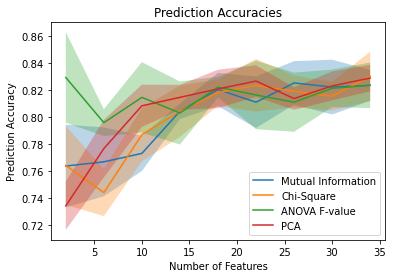

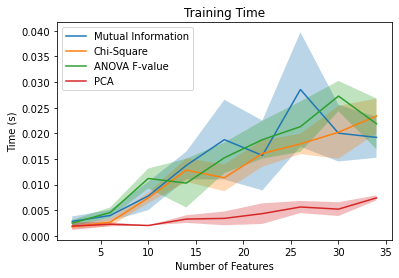

In [26]:
fig, ax = plt.subplots()
ax.plot(num_features, mi_acc_mean, label= 'Mutual Information')
ax.plot(num_features, chi_acc_mean, label = 'Chi-Square')
ax.plot(num_features, fval_acc_mean, label = 'ANOVA F-value')
ax.plot(num_features, pca_acc_mean, label = 'PCA')
ax.fill_between(num_features, mi_acc_mean+mi_acc_stds, mi_acc_mean-mi_acc_stds, alpha=0.3)
ax.fill_between(num_features, chi_acc_mean+chi_acc_stds, chi_acc_mean-chi_acc_stds, alpha=0.3)
ax.fill_between(num_features, fval_acc_mean+fval_acc_stds, fval_acc_mean-fval_acc_stds, alpha=0.3)
ax.fill_between(num_features, pca_acc_mean+pca_acc_stds, pca_acc_mean-pca_acc_stds, alpha=0.3)
ax.set(title="Prediction Accuracies", xlabel="Number of Features", ylabel="Prediction Accuracy")
plt.legend()
plt.show()

# Plot timing
fig, ax = plt.subplots()
ax.plot(num_features, mi_time_mean, label= 'Mutual Information')
ax.fill_between(num_features, mi_time_mean+mi_time_stds, mi_time_mean-mi_time_stds, alpha=0.3)
ax.plot(num_features, chi_time_mean, label = 'Chi-Square')
ax.fill_between(num_features, chi_time_mean+chi_time_stds, chi_time_mean-chi_time_stds, alpha=0.3)
ax.plot(num_features, fval_time_mean, label = 'ANOVA F-value')
ax.fill_between(num_features, fval_time_mean+fval_time_stds, fval_time_mean-fval_time_stds, alpha=0.3)
ax.plot(num_features, pca_time_mean, label= 'PCA')
ax.fill_between(num_features, pca_time_mean+pca_time_stds, pca_time_mean-pca_time_stds, alpha=0.3)
ax.set(title="Training Time", xlabel="Number of Features", ylabel="Time (s)")
plt.legend()
plt.show()

In [33]:
err = 0.000002
def get_optimal_accuracy(num_features, model = None,err=0.03, name=None, run_time = None):
    for i in range (0,len(num_features)):
        if model[i+1] - model[i] <= err:
            model_f = i
            break
    print(f'{name} with {num_features[model_f]+2} features, the accuracy is {model[i]:1.3f} and takes {run_time[i]:1.3f} sec')
    
get_optimal_accuracy(num_features, model = mi_acc_mean, name= 'Mutual Information', run_time = mi_time_mean)
get_optimal_accuracy(num_features, model = chi_acc_mean, name= 'Chi squared', run_time = chi_time_mean)
get_optimal_accuracy(num_features, model = fval_acc_mean, name= 'ANOVA F-value', run_time = fval_time_mean)
get_optimal_accuracy(num_features, model = pca_acc_mean, name= 'PCA', run_time = pca_time_mean)

Mutual Information with 4 features, the accuracy is 0.764 and takes 0.003 sec
Chi squared with 4 features, the accuracy is 0.764 and takes 0.002 sec
ANOVA F-value with 4 features, the accuracy is 0.829 and takes 0.002 sec
PCA with 12 features, the accuracy is 0.808 and takes 0.002 sec
